In [3]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
from ipywidgets import widgets
import ConfigReader as cr

In [4]:
#Styles
sns.set_style('darkgrid')
sns.set_color_codes()
plt.rcParams['figure.figsize'] = (12.0, 9.0)

plt.rc('text', usetex=False)
plt.rc('font', size=20.0, family='serif')

In [5]:
# Data location and dataset
data_dir = '/mhome/mendozah/constrained_DeepNet_Configs/policy_results/'
dataset = '554_bac'

In [6]:
reader = cr.ConfigReader(data_dir=data_dir, dataset=dataset)

In [9]:
# Explicitely set the preprocessor to none
tdf,_ = reader.load_run_configs(preprocessor=None)

In [10]:
# Calculate the number of epochs based on the updates and batch size
trainset_size = 42210
tdf['epochs'] = np.floor((tdf.batch_size * tdf.number_updates)/trainset_size)

In [11]:
tdf.shape

(706, 40)

In [12]:
# Plot the empirical CDF
sorted_Y = (tdf.sort_values(by='response', ascending=True)['response'].values)
yvals = np.arange(len(sorted_Y)) / float(len(sorted_Y))

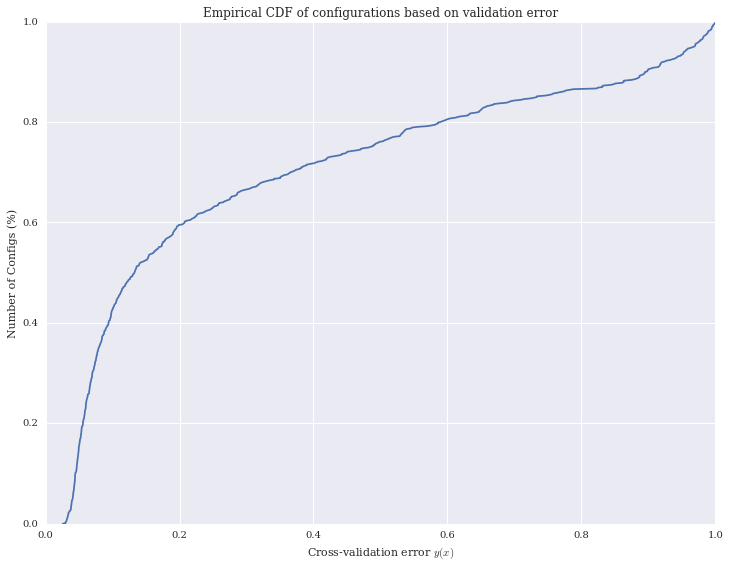

In [13]:
plt.plot( sorted_Y, yvals )
plt.xlabel("Cross-validation error $y(x)$")
plt.ylabel(r"Number of Configs (%)")
plt.xlim(0.0, 1.0)
plt.title("Empirical CDF of configurations based on validation error")
plt.show()

In [103]:
# Start filtering the error
err_threshold = 0.2
less_threshold = True

if less_threshold:
    filtered = tdf[tdf.response <= err_threshold]
else:
    filtered = tdf[tdf.response >= err_threshold]
        
print filtered.shape

(421, 40)


## After Setting the frames. Start with the plotting

In [14]:
## TODO: Review how to make filtered and the figure return
def plotting_threshold(error_threshold, categories):
    #global filtered
    filtered = tdf[tdf.response <= error_threshold]
    fig_f, axs = plt.subplots(ncols=2,nrows=1, figsize=(15.0, 8.5))
    ax0, ax1 = axs.flat
    sns.boxplot(x=categories, y='response', data=filtered, ax=ax0)
    sns.countplot(y=categories, data=filtered, ax=ax1)
    fig_f.tight_layout()

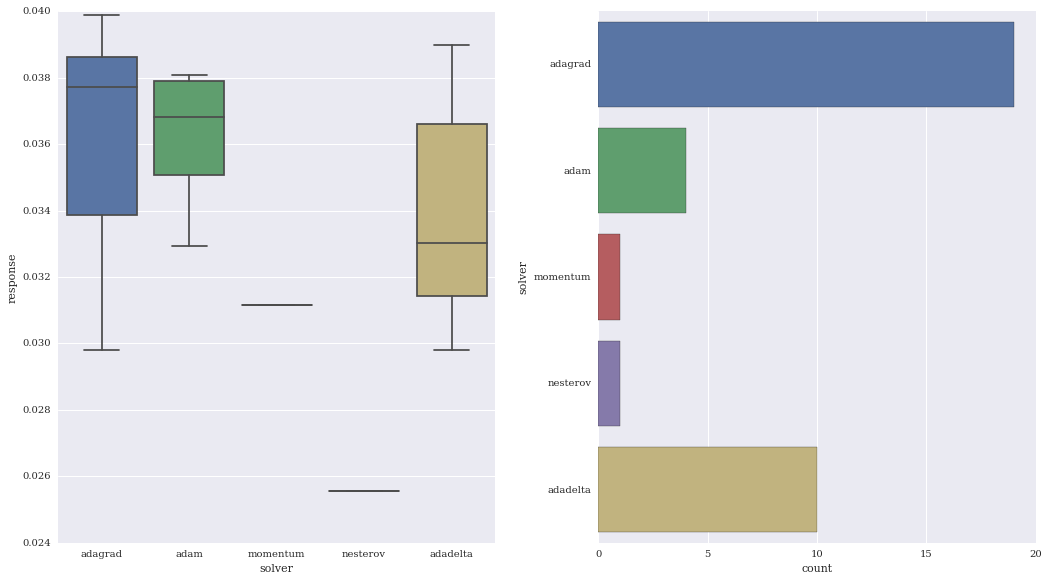

In [15]:
widgets.interact(plotting_threshold, error_threshold=(0.01,0.2,0.01),
                 categories={'Solver':'solver', 'Policy':'lr_policy'})

In [53]:
# Create the grouping of the filtered DF
solver_filt = filtered.groupby('solver')

In [ ]:
g_scatterGrid = sns.FacetGrid(data=filtered, col='solver',
                              col_wrap=3, size=3.5, aspect=1.2)
g_scatterGrid.map(plt.scatter, 'learning_rate', 'performance', s=70)
g_scatterGrid.set(ylim=(0.05,0.20), yticks=np.linspace(0.05,0.20,5),
                  xlim=(-0.01, 0.35), xticks=np.linspace(0.0, 0.30, 7))
g_scatterGrid.add_legend()
g_scatterGrid.fig.suptitle('Error vs learning rate for each solver labeled for policy',
                           fontsize=12, y=1.02)
g_scatterGrid.fig.subplots_adjust(wspace=.05, hspace=.1)

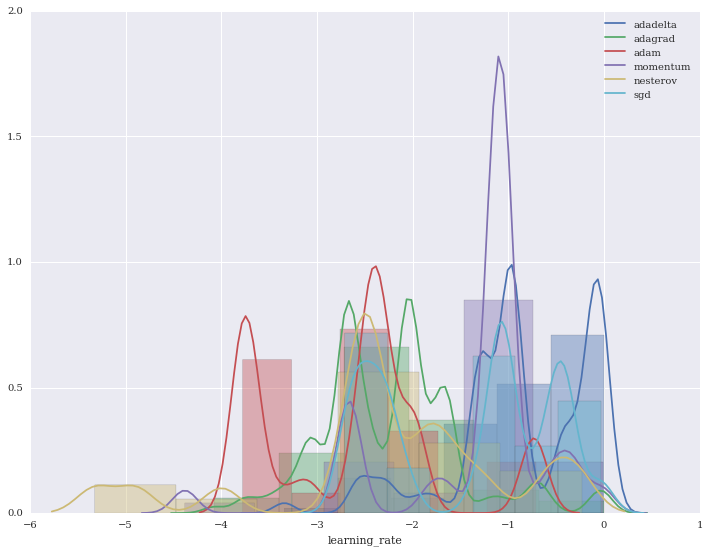

In [113]:
# Seaborns Normed Distribution plots
for name,groups in solver_filt:
    sns.distplot(np.log10(groups.learning_rate), bins=6, kde_kws={'label':name, 'bw':0.15})

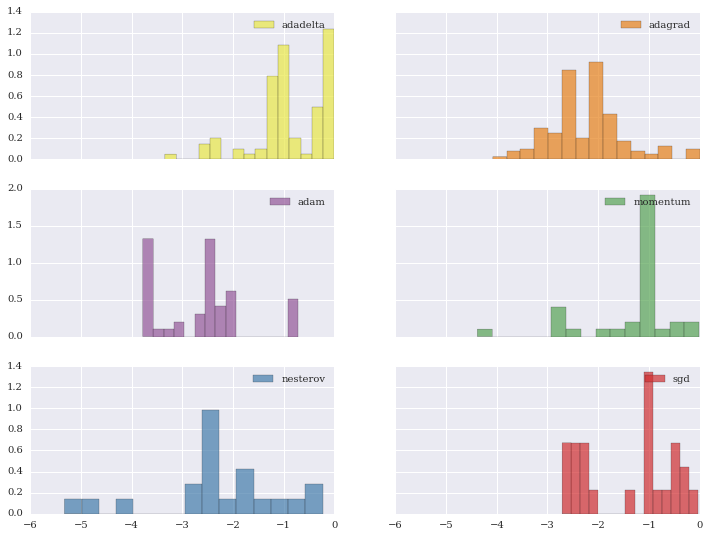

In [116]:
#Subplots of the previous histogram
color_histograms = sns.color_palette('Set1',6, desat=0.8)
fig1, axs = plt.subplots(nrows=3, ncols=2, sharey='row', sharex=True)
for iterate_axis, (name, groups) in zip(axs.flat, solver_filt):
    iterate_axis.hist(np.log10(groups.learning_rate.values), bins=15, histtype='bar', normed=1,
                         stacked=False, label=name, alpha=0.7, color=color_histograms.pop())
    iterate_axis.legend()

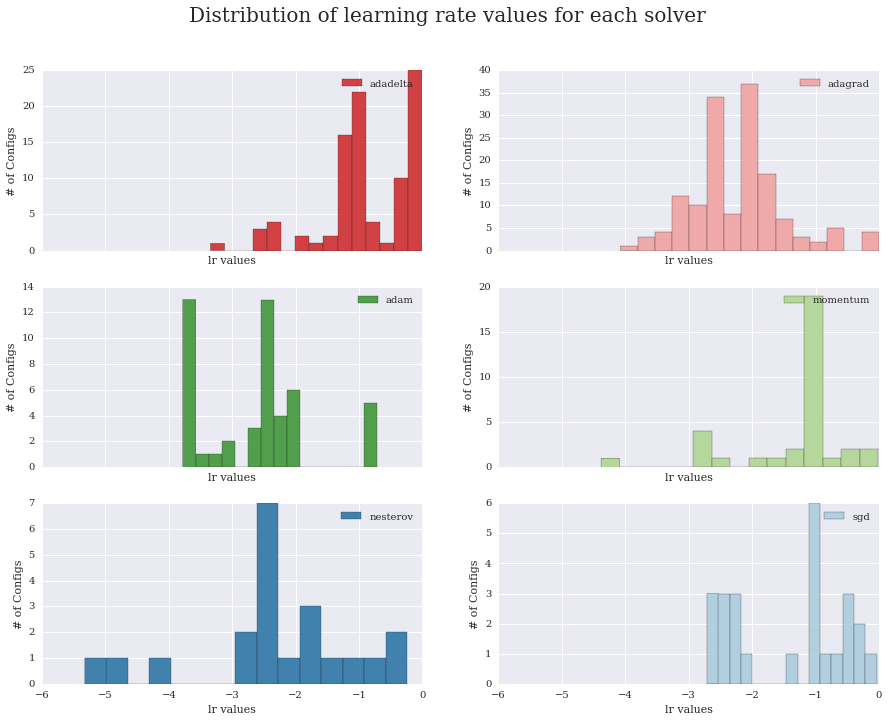

In [114]:
col_hist = sns.color_palette('Paired',6, desat=0.8)

fig2, axs = plt.subplots(nrows=3, ncols=2, sharex=True, figsize=(15.,11.))
fig2.suptitle('Distribution of learning rate values for each solver')
for ax, (name, groups) in zip(axs.flat,solver_filt):
    ax.hist(np.log10(groups.learning_rate.values), bins=15, histtype='bar', fill=True,
            label=name, alpha=0.9, color=col_hist.pop())
    ax.set_xlabel('lr values')
    ax.set_ylabel('# of Configs')
    ax.legend()

In [68]:
# Create the grouping of the filtered DF
prepro_filt = filtered.groupby('lr_policy')

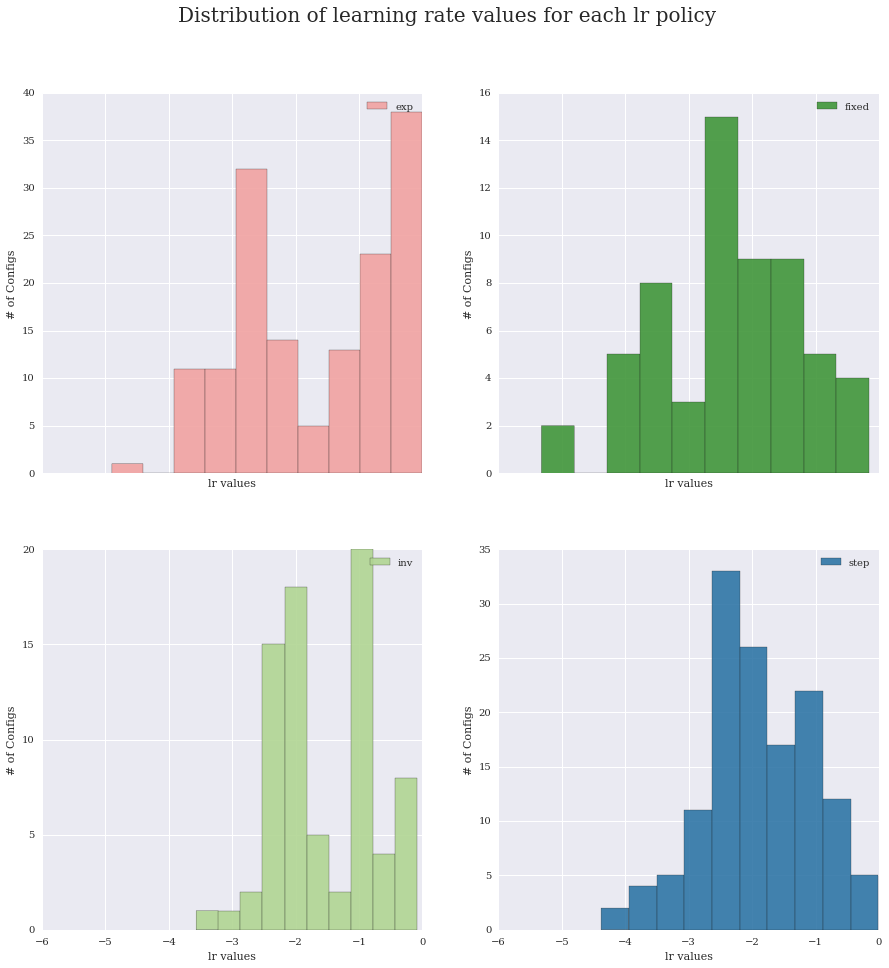

In [72]:
prepro_color = sns.color_palette('Paired',5, desat=0.8)

fig4, axs = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(15.,15.))
fig4.suptitle('Distribution of learning rate values for each lr policy')
for ax, (name, groups) in zip(axs.flat,prepro_filt):
    ax.hist(np.log10(groups.learning_rate.values), bins=10, histtype='bar', fill=True, label=name,
            alpha=0.9, color=prepro_color.pop())
    ax.set_xlabel('lr values')
    ax.set_ylabel('# of Configs')
    ax.legend()

In [ ]:
# Due to 'hacky' layer conditioning -- Hopefully will be removed in the future
filtered.loc['num_layers'] = filtered['num_layers'].map(lambda x: ord(x)-ord('c'))

In [125]:
pd.Series(filtered.columns)

0             config_id
1              response
2               runtime
3             smac_iter
4           cum_runtime
5            run_result
6            batch_size
7                 beta1
8                 beta2
9       dropout_layer_1
10      dropout_layer_2
11      dropout_layer_3
12      dropout_layer_4
13      dropout_layer_5
14      dropout_layer_6
15       dropout_output
16           epoch_step
17                gamma
18              lambda2
19        learning_rate
20            lr_policy
21             momentum
22           num_layers
23    num_units_layer_1
24    num_units_layer_2
25    num_units_layer_3
26    num_units_layer_4
27    num_units_layer_5
28    num_units_layer_6
29       number_updates
30                power
31                  rho
32               solver
33          std_layer_1
34          std_layer_2
35          std_layer_3
36          std_layer_4
37          std_layer_5
38          std_layer_6
39               epochs
dtype: object

In [23]:
# Discard values of unused units, std and dropout
def purge_extra_params(x):
    nl = x['num_layers']
    x.iloc[9 + nl: 15] = -1
    x.iloc[23 + nl: 29] = -1
    x.iloc[33 + nl: 39] = -1
    return x

In [24]:
rt = filtered.apply(purge_extra_params,axis=1)

In [25]:
t = rt.replace(-1., np.nan)

In [19]:
def histogram_group_column_plotting(grouping, column):
    #Have to convert the -1 to NaN
    g = t.groupby(grouping)
    s = len(g)
    col_hist = sns.color_palette('Paired',s, desat=0.8)
    fig_hist, axs = plt.subplots(nrows=s/2, ncols=2, sharex='col', sharey='row', figsize=(15., 11.))
    for ax, (name, groups) in zip(axs.flat,g):
        ax.hist(groups[column].dropna().values, bins=15,
                histtype='bar', fill=True, label=name, alpha=0.9, color=col_hist.pop())
        ax.set_xlabel(column + ' values')
        ax.set_ylabel('# of Configs')
        ax.legend()
    fig_hist.suptitle('Distribution of '+ column +' values for each '+(grouping))

In [20]:
# Create columns dict
Groups = ['solver','preprocessor']
Plott = {'# of Epochs':'number_epochs', 'batch size':'batch_size','# of Layers':'num_layers',
         'Units of Layer 1':'num_units_layer_1', 'Units of Layer 2':'num_units_layer_2',
         'Units of Layer 3':'num_units_layer_3', 'Units of Layer 4':'num_units_layer_4',
         'Units of Layer 5':'num_units_layer_5', 'Units of Layer 6':'num_units_layer_6',
         'Dropout rate of layer 1':'dropout_layer_1', 'Dropout rate of layer 2':'dropout_layer_2',
         'Dropout rate of layer 3':'dropout_layer_3', 'Dropout rate of layer 4':'dropout_layer_4',
         'Dropout rate of layer 5':'dropout_layer_5', 'Dropout rate at output':'dropout_output',
         'std of layers':'std_layer_1', 'std of layer 2':'std_layer_2', 'std of layer 3':'std_layer_3',
         'std of layer 4':'std_layer_4','std of layer 5':'std_layer_5'}

<function __main__.histogram_group_column_plotting>

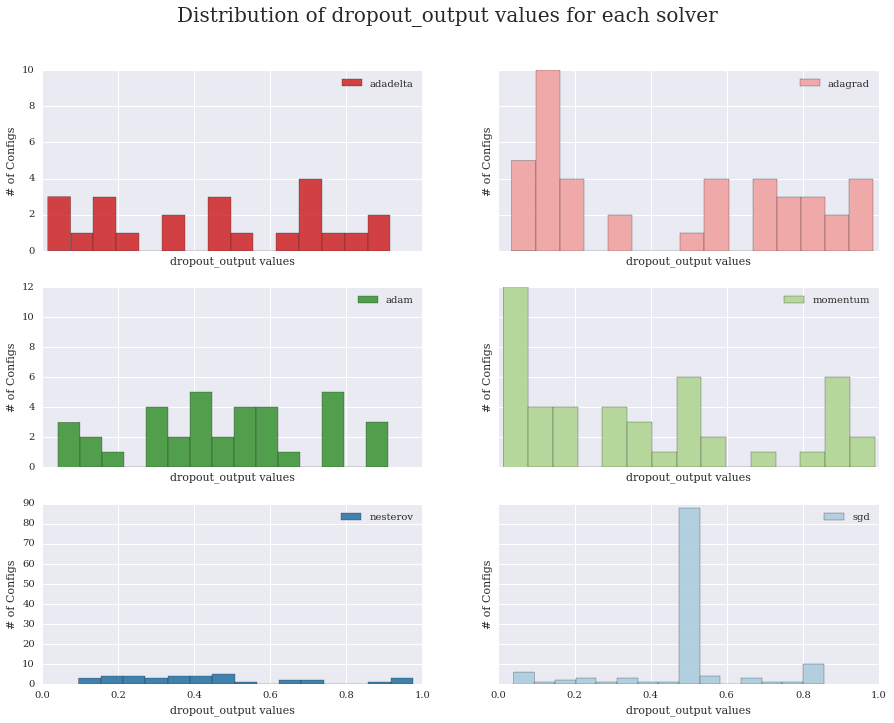

In [26]:
widgets.interact(histogram_group_column_plotting, grouping=Groups, column=Plott)

### Distribution of each parameter over all filtered configurations

In [27]:
def histogram_column_plotting(column):
    #Have to convert the -1 to NaN
    rt = filtered.apply(purge_extra_params,axis=1)
    addMissing_df = rt.replace(-1., np.nan)
    fig_hist = plt.figure(6)
    ax1 = plt.subplot(111)
    ax1.set_title('Histogram of '+column)
    addMissing_df[column].plot(kind='hist', bins=15, ax=ax1)
    ax1.set_xlabel('values')

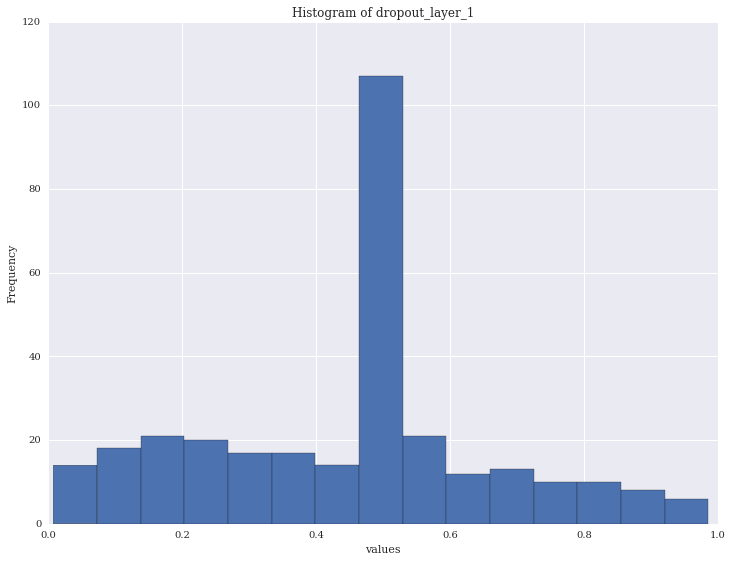

In [28]:
widgets.interact(histogram_column_plotting, column=list(filtered.columns.values[:-1]))